#Consultas básicas de la base de datos

## 1. Conexión y descripción de tablas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

import warnings
warnings.filterwarnings('ignore')

In [336]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [337]:
db_path = '/content/drive/MyDrive/Bootcamp analisis de datos/energy_database.db'
conn = sqlite3.connect(db_path)

In [338]:
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()


[('countries',),
 ('group_technology',),
 ('technology',),
 ('sub_technology',),
 ('producer_type',),
 ('energy_data',)]

###1.1. Descripción tablas

In [339]:
c_query = """
PRAGMA table_info(countries);
"""
cur.execute(c_query)
cur.fetchall()

[(0, 'country_id', 'TINYINT', 0, None, 1),
 (1, 'name', 'VARCHAR(50)', 1, None, 0)]

In [340]:
pt_query ="PRAGMA table_info(producer_type);"
cur.execute(pt_query)
cur.fetchall()

[(0, 'producer_type_id', 'TINYINT', 0, None, 1),
 (1, 'type', 'TEXT', 1, None, 0)]

In [341]:
gt_query = "PRAGMA table_info(group_technology);"
cur.execute(gt_query)
cur.fetchall()

[(0, 'group_technology_id', 'TINYINT', 0, None, 1),
 (1, 'name', 'VARCHAR(50)', 1, None, 0),
 (2, 'renewable', 'BOOLEAN', 1, None, 0)]

In [342]:
t_query = "PRAGMA table_info(technology);"
cur.execute(t_query)
cur.fetchall()

[(0, 'technology_id', 'TINYINT', 1, None, 1),
 (1, 'name', 'VARCHAR(50)', 1, None, 0),
 (2, 'group_technology_id', 'TINYINT', 1, None, 0)]

In [343]:
st_query = "PRAGMA table_info(sub_technology);"
cur.execute(st_query)
cur.fetchall()

[(0, 'sub_technology_id', 'TINYINT', 0, None, 1),
 (1, 'name', 'VARCHAR(50)', 1, None, 0),
 (2, 'technology_id', 'TINYINT', 1, None, 0)]

In [344]:
data_query = "PRAGMA table_info(energy_data);"
cur.execute(data_query)
cur.fetchall()

[(0, 'id', 'SMALLINT', 1, None, 1),
 (1, 'country_id', 'TINYINT', 1, None, 0),
 (2, 'sub_tech_id', 'TINYINT', 1, None, 0),
 (3, 'producer_type_id', 'TINYINT', 1, None, 0),
 (4, 'year', 'INTEGER', 1, None, 0),
 (5, 'electricity_generation_gwh', 'FLOAT', 0, None, 0),
 (6, 'electricity_installed_mw', 'FLOAT', 0, None, 0),
 (7, 'public_flows_2022_usdm', 'FLOAT', 0, None, 0),
 (8, 'international_public_flows_7a1', 'FLOAT', 0, None, 0),
 (9, 'renewable_installed_per_capita_whab', 'FLOAT', 0, None, 0)]

##2. Utilización de energía renovable y no renovable

###2.1. Midiendo a partir de la generación de energía

In [345]:
year = 2018

In [346]:
query_1 = f"""
SELECT c.name, SUM(ed.electricity_generation_gwh) AS total_renewable_gwh
FROM energy_data ed
INNER JOIN countries c ON ed.country_id = c.country_id
WHERE ed.sub_tech_id IN
(
  SELECT st.sub_technology_id
  FROM sub_technology st
  INNER JOIN technology t ON st.technology_id = t.technology_id
  INNER JOIN group_technology gt ON t.group_technology_id = gt.group_technology_id
  WHERE gt.renewable = TRUE
)
AND ed.year = {year}
GROUP BY c.country_id
"""
cur.execute(query_1)
renewables = pd.DataFrame(cur.fetchall())
renewables.columns = [i[0] for i in cur.description]
renewables

,name,total_renewable_gwh
0,Argentina,35357.39
1,Brazil,494917.66
2,Chile,38135.82
3,Colombia,61754.17
4,Peru,33300.08
5,Uruguay,13945.27


In [347]:
query_2 = f"""
SELECT c.name, SUM(ed.electricity_generation_gwh) AS total_non_renewable_gwh
FROM energy_data ed
INNER JOIN countries c ON ed.country_id = c.country_id
WHERE ed.sub_tech_id IN
(
  SELECT st.sub_technology_id
  FROM sub_technology st
  INNER JOIN technology t ON st.technology_id = t.technology_id
  INNER JOIN group_technology gt ON t.group_technology_id = gt.group_technology_id
  WHERE gt.renewable = FALSE
)
AND ed.year = {year}
GROUP BY c.country_id
"""
cur.execute(query_2)
non_renewables = pd.DataFrame(cur.fetchall())
non_renewables.columns = [i[0] for i in cur.description]
non_renewables

,name,total_non_renewable_gwh
0,Argentina,111185.92
1,Brazil,111913.32
2,Chile,44702.70
3,Colombia,18738.58
4,Peru,21121.66
5,Uruguay,689.36


In [348]:
energy_usage = pd.merge(renewables, non_renewables, on='name', suffixes=('_renewable', '_non_renewable'))
energy_usage['total_energy_production_gwh'] = energy_usage['total_renewable_gwh'] + energy_usage['total_non_renewable_gwh']
energy_usage

,name,total_renewable_gwh,total_non_renewable_gwh,total_energy_production_gwh
0,Argentina,35357.39,111185.92,146543.31
1,Brazil,494917.66,111913.32,606830.98
2,Chile,38135.82,44702.70,82838.52
3,Colombia,61754.17,18738.58,80492.75
4,Peru,33300.08,21121.66,54421.74
5,Uruguay,13945.27,689.36,14634.63


<Axes: title={'center': 'Producción de energía por país en 2018'}, xlabel='País', ylabel='Porcentaje Energía generada (%)'>

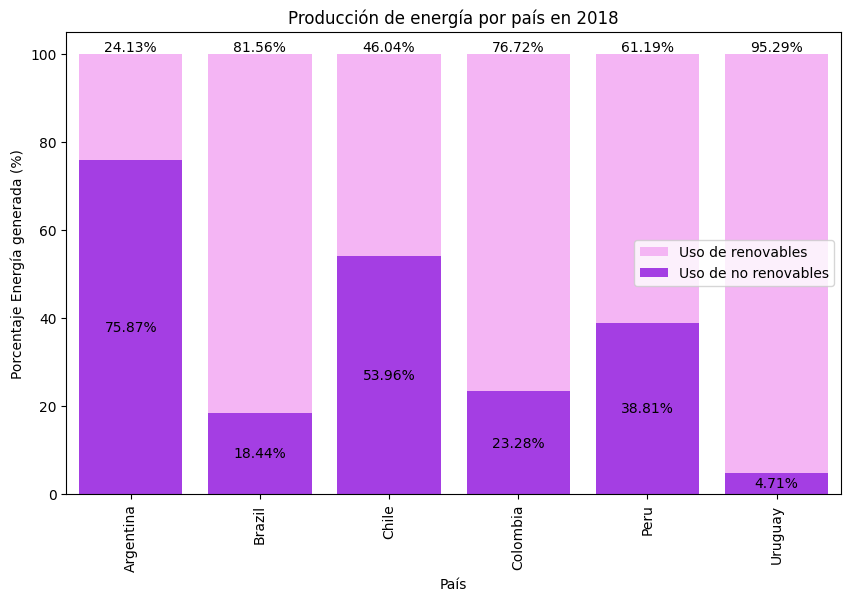

In [358]:
fig, ax = plt.subplots(figsize=(10, 6))

non_renewables_percentage = energy_usage['total_non_renewable_gwh']/energy_usage['total_energy_production_gwh']*100
renewables_percentage = non_renewables_percentage + energy_usage['total_renewable_gwh']/energy_usage['total_energy_production_gwh']*100

ax_1 = sns.barplot(data=energy_usage, x='name', y=renewables_percentage, label='Uso de renovables', color='#ffaaff')
ax_2 = sns.barplot(data=energy_usage, x='name', y=non_renewables_percentage, label='Uso de no renovables', color='#aa22ff')

ax_1.bar_label(container=ax_1.containers[0],
               labels=[f'{val:.2f}%' for val in (renewables_percentage-non_renewables_percentage)],
               fontsize=10)

ax_2.bar_label(ax_2.containers[1],label_type='center',
               labels=[f'{val:.2f}%' for val in non_renewables_percentage],
               fontsize=10)

ax.set_title(f'Producción de energía por país en {year}')
ax.set_xlabel('País')
ax.set_ylabel('Porcentaje Energía generada (%)')
ax.set_xticks(ticks=energy_usage['name'].values, labels=energy_usage['name'].values, rotation=90)
ax

In [355]:
plt.show()

###2.2. Midieando a partir de la capacidad instalada

In [141]:
year = 2018

In [142]:
query_1 = f"""
SELECT c.name, SUM(ed.electricity_installed_mw) AS total_renewable_mw
FROM energy_data ed
INNER JOIN countries c ON ed.country_id = c.country_id
WHERE ed.sub_tech_id IN
(
  SELECT st.sub_technology_id
  FROM sub_technology st
  INNER JOIN technology t ON st.technology_id = t.technology_id
  INNER JOIN group_technology gt ON t.group_technology_id = gt.group_technology_id
  WHERE gt.renewable = TRUE
)
AND ed.year = {year}
GROUP BY c.country_id
"""
cur.execute(query_1)
renewables = pd.DataFrame(cur.fetchall())
renewables.columns = [i[0] for i in cur.description]
renewables

,name,total_renewable_mw
0,Argentina,11509.90
1,Brazil,139871.91
2,Chile,11158.92
3,Colombia,12195.55
4,Peru,6123.03
5,Uruguay,3727.85


In [143]:
query_2 = f"""
SELECT c.name, SUM(ed.electricity_installed_mw) AS total_non_renewable_mw
FROM energy_data ed
INNER JOIN countries c ON ed.country_id = c.country_id
WHERE ed.sub_tech_id IN
(
  SELECT st.sub_technology_id
  FROM sub_technology st
  INNER JOIN technology t ON st.technology_id = t.technology_id
  INNER JOIN group_technology gt ON t.group_technology_id = gt.group_technology_id
  WHERE gt.renewable = FALSE
)
AND ed.year = {year}
GROUP BY c.country_id
"""
cur.execute(query_2)
non_renewables = pd.DataFrame(cur.fetchall())
non_renewables.columns = [i[0] for i in cur.description]
non_renewables

,name,total_non_renewable_mw
0,Argentina,27752.33
1,Brazil,27648.11
2,Chile,16393.00
3,Colombia,5540.47
4,Peru,8568.09
5,Uruguay,1186.70


In [144]:
energy_installed = pd.merge(renewables, non_renewables, on='name', suffixes=('_renewable', '_non_renewable'))
energy_installed['total_energy_installed_mw'] = energy_installed['total_renewable_mw'] + energy_installed['total_non_renewable_mw']
energy_installed

,name,total_renewable_mw,total_non_renewable_mw,total_energy_installed_mw
0,Argentina,11509.90,27752.33,39262.23
1,Brazil,139871.91,27648.11,167520.02
2,Chile,11158.92,16393.00,27551.92
3,Colombia,12195.55,5540.47,17736.02
4,Peru,6123.03,8568.09,14691.12
5,Uruguay,3727.85,1186.70,4914.55


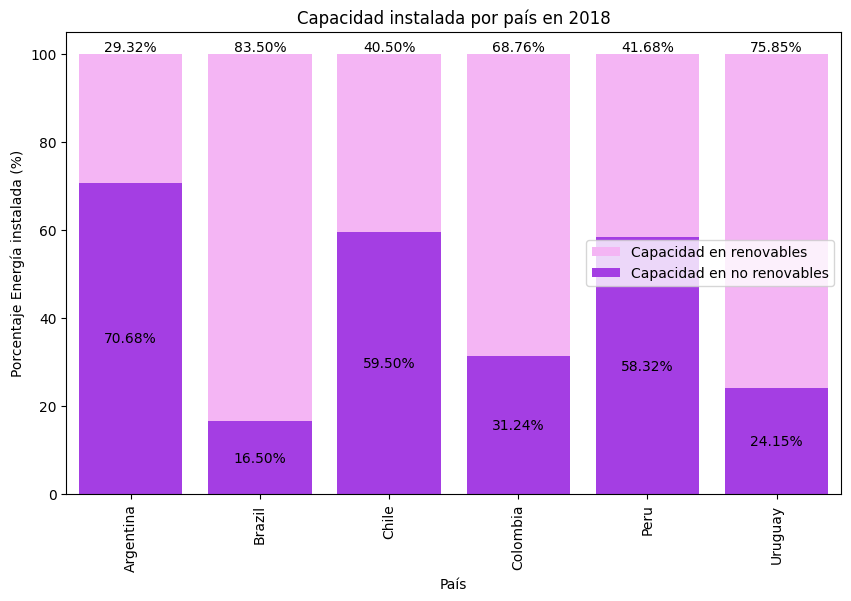

In [237]:
fig, ax = plt.subplots(figsize=(10, 6))

non_renewables_percentage = energy_installed['total_non_renewable_mw']/energy_installed['total_energy_installed_mw']*100
renewables_percentage = non_renewables_percentage + energy_installed['total_renewable_mw']/energy_installed['total_energy_installed_mw']*100

ax_1 = sns.barplot(data=energy_usage, x='name', y=renewables_percentage, label='Capacidad en renovables', color='#ffaaff')
ax_2 = sns.barplot(data=energy_usage, x='name', y=non_renewables_percentage, label='Capacidad en no renovables', color='#aa22ff')

ax_1.bar_label(container=ax_1.containers[0],
               labels=[f'{val:.2f}%' for val in (renewables_percentage-non_renewables_percentage)],
               fontsize=10)

ax_2.bar_label(ax_2.containers[1],label_type='center',
               labels=[f'{val:.2f}%' for val in non_renewables_percentage],
               fontsize=10)

plt.title(f'Capacidad instalada por país en {year}')
plt.xlabel('País')
plt.ylabel('Porcentaje Energía instalada (%)')
plt.legend(loc='best')
plt.xticks(rotation=90)
plt.show()


###2.3. Parametrizando la columna de medición

In [254]:
ed_query="PRAGMA table_info(energy_data);"
cur.execute(ed_query)
cur.fetchall()
#

[(0, 'id', 'SMALLINT', 1, None, 1),
 (1, 'country_id', 'TINYINT', 1, None, 0),
 (2, 'sub_tech_id', 'TINYINT', 1, None, 0),
 (3, 'producer_type_id', 'TINYINT', 1, None, 0),
 (4, 'year', 'INTEGER', 1, None, 0),
 (5, 'electricity_generation_gwh', 'FLOAT', 0, None, 0),
 (6, 'electricity_installed_mw', 'FLOAT', 0, None, 0),
 (7, 'public_flows_2022_usdm', 'FLOAT', 0, None, 0),
 (8, 'international_public_flows_7a1', 'FLOAT', 0, None, 0),
 (9, 'renewable_installed_per_capita_whab', 'FLOAT', 0, None, 0)]

Generamos diccionarios entre entrada de selectbox y nombres de columnas de interés:

1. Generación de energía (GWh): electricity_generation_gwh
2. Capacidad instalada (MW): electricity_installed_mw
3. Inversión publica (2022 USD M): public_flows_2022_usdm
4. Inversión pública SDG 7a1: international_public_flows_7a1
5. Capacidad renovable per capita SDG 7b1 (W/hab): renewable_installed_per_capita_whab


In [255]:
data_col_dict = {'Generación de energía (GWh)':'electricity_generation_gwh',
                 'Capacidad instalada (MW)':'electricity_installed_mw',
                 'Inversión publica (2022 USD M)':'public_flows_2022_usdm',
                 'Inversión pública SDG 7a1':'international_public_flows_7a1',
                 'Capacidad renovable per capita SDG 7b1 (W/hab)':'renewable_installed_per_capita_whab'}


In [256]:
select_box_value = 'Generación de energía (GWh)'
col = data_col_dict[select_box_value]


In [246]:
query_1 = f"""
SELECT c.name, SUM({col}) AS total_renewable
FROM energy_data ed
INNER JOIN countries c ON ed.country_id = c.country_id
WHERE ed.sub_tech_id IN
(
  SELECT st.sub_technology_id
  FROM sub_technology st
  INNER JOIN technology t ON st.technology_id = t.technology_id
  INNER JOIN group_technology gt ON t.group_technology_id = gt.group_technology_id
  WHERE gt.renewable = TRUE
)
AND ed.year = {year}
GROUP BY c.country_id
"""
cur.execute(query_1)
renewables = pd.DataFrame(cur.fetchall())
renewables.columns = [i[0] for i in cur.description]
renewables

,name,total_renewable
0,Argentina,35357.39
1,Brazil,494917.66
2,Chile,38135.82
3,Colombia,61754.17
4,Peru,33300.08
5,Uruguay,13945.27


In [247]:
query_2 = f"""
SELECT c.name, SUM({col}) AS total_non_renewable
FROM energy_data ed
INNER JOIN countries c ON ed.country_id = c.country_id
WHERE ed.sub_tech_id IN
(
  SELECT st.sub_technology_id
  FROM sub_technology st
  INNER JOIN technology t ON st.technology_id = t.technology_id
  INNER JOIN group_technology gt ON t.group_technology_id = gt.group_technology_id
  WHERE gt.renewable = FALSE
)
AND ed.year = {year}
GROUP BY c.country_id
"""
cur.execute(query_2)
non_renewables = pd.DataFrame(cur.fetchall())
non_renewables.columns = [i[0] for i in cur.description]
non_renewables

,name,total_non_renewable
0,Argentina,111185.92
1,Brazil,111913.32
2,Chile,44702.70
3,Colombia,18738.58
4,Peru,21121.66
5,Uruguay,689.36


In [252]:
energy_data = pd.merge(renewables, non_renewables, on='name', suffixes=('_renewable', '_non_renewable'))
energy_data['total_energy'] = energy_data['total_renewable'] + energy_data['total_non_renewable']
energy_data

,name,total_renewable,total_non_renewable,total_energy
0,Argentina,35357.39,111185.92,146543.31
1,Brazil,494917.66,111913.32,606830.98
2,Chile,38135.82,44702.70,82838.52
3,Colombia,61754.17,18738.58,80492.75
4,Peru,33300.08,21121.66,54421.74
5,Uruguay,13945.27,689.36,14634.63


Para graficar se usaran diccionarios de nombramiento de etiquetas y ejes de acuerdo a columna seleccionada

**Etiquetas**

1. Generación de energía (GWh): [Producción energía renovables, Producción de energía no renovables]
2. Capacidad instalada (MW): [Capacidad en renovables, Capacidad en no renovables]
3. Inversión publica (2022 USD M): [Inversion en renovables, Inversion en no renovables]
4. Inversión pública SDG 7a1 (2022 USD M): Inversión en energías renovables SDG 7a1
5. Capacidad renovable per capita SDG 7b1 (W/hab): Capacidad en renovables SDG 7b1

**Eje vertical**

1. Generación de energía (GWh): Porcentajes de producción de energía (%)
2. Capacidad instalada (MW): Porcentajes de capacidad instalada (%)
3. Inversión publica (2022 USD M):
4. Inversión pública SDG 7a1 (2022 USD M): Inversión en energías renovables por país en año ...
5. Capacidad renovable per capita SDG 7b1 (W/hab): Capacidad per capita en renovables por pais en año ...

**Titulos gráficos**

1. Generación de energía (GWh): Producción de energía por pais en año ...
2. Capacidad instalada (MW): Capacidad instalada por pais en año ...
3. Inversión publica (2022 USD M): Inversion por país en año ..
4. Inversión pública SDG 7a1 (2022 USD M): Inversión en energías renovables por país en año ...
5. Capacidad renovable per capita SDG 7b1 (W/hab): Capacidad per capita en renovables por pais en año ...

In [258]:
axis_labels_dict = {'Generación de energía (GWh)':['Producción de energía renovable', 'Producción de energía no renovables'],
                      'Capacidad instalada (MW)':['Capacidad instalada en renovables', 'Capacidad instalada en no renovables'],
                      'Inversión publica (2022 USD M)':['Inversión en energías renovables', 'Inversión en energías no renovables'],
                      'Inversión pública SDG 7a1 (2022 USD M)':'Inversión en energías renovables SDG 7a1',
                      'Capacidad renovable per capita SDG 7 (W/hab)':'Capacidad en energías renovables SDG 7b1'}

titles_dict = {'Generación de energía (GWh)':'Producción de energía por pais en año',
                      'Capacidad instalada (MW)':'Capacidad instalada por pais en año',
                      'Inversión publica (2022 USD M)':'Inversión por país en año',
                      'Inversión pública SDG 7a1 (2022 USD M)':'Inversión en energías renovables por país en año',
                      'Capacidad renovable per capita SDG 7 (W/hab)':'Capacidad per capita en renovables por pais en año'}


In [259]:
title = titles_dict[select_box_value] + f' {year}'
axis_labels = axis_labels_dict[select_box_value]

In [260]:
type(axis_labels)

list

In [262]:
type(axis_labels) == type(list())

True

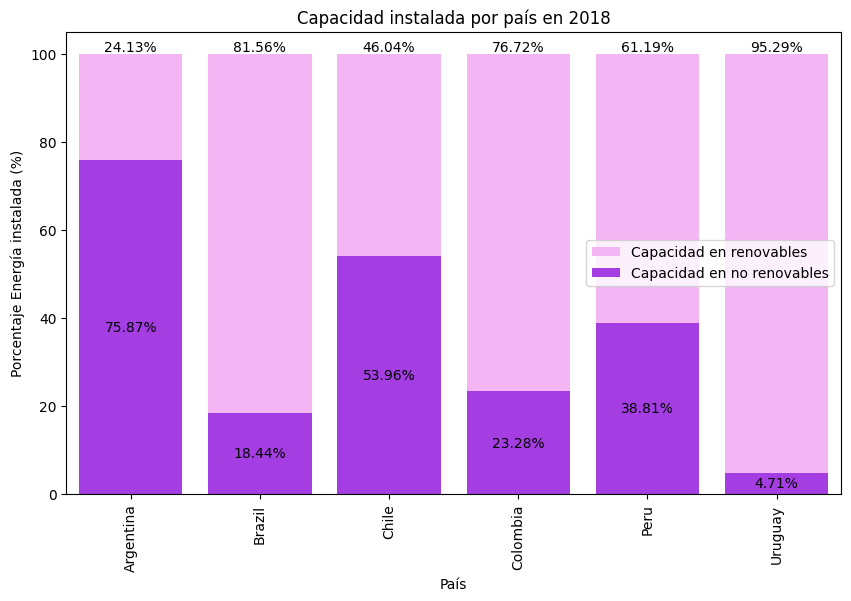

In [253]:
fig, ax = plt.subplots(figsize=(10, 6))

non_renewables_percentage = energy_data['total_non_renewable']/energy_data['total_energy']*100
renewables_percentage = non_renewables_percentage + energy_data['total_renewable']/energy_data['total_energy']*100

if type(axis_labels) == type(list()):

  ax_1 = sns.barplot(data=energy_usage, x='name', y=renewables_percentage, label='Capacidad en renovables', color='#ffaaff')
  ax_2 = sns.barplot(data=energy_usage, x='name', y=non_renewables_percentage, label='Capacidad en no renovables', color='#aa22ff')

  ax_1.bar_label(container=ax_1.containers[0],
                labels=[f'{val:.2f}%' for val in (renewables_percentage-non_renewables_percentage)],
                fontsize=10)

  ax_2.bar_label(ax_2.containers[1],label_type='center',
                labels=[f'{val:.2f}%' for val in non_renewables_percentage],
               fontsize=10)

else:
  ax = sns.barplot(data=energy_data, x='name', y=renewables_percentage, label='Capacidad en renovables', color='#ffaaff')
  ax.bar_label(ax.containers[0],label_type='center',
               labels=[f'{val:.2f}%' for val in renewables_percentage],
               fontsize=10)

plt.title(title)
plt.xlabel('País')
plt.ylabel('Porcentaje Energía instalada (%)')
plt.legend(loc='best')
plt.xticks(rotation=90)
plt.show()

##3. Detallando energías renovables por país

In [146]:
cur.execute("SELECT * FROM sub_technology;").fetchall()

[(0, 'Bagasse', 18),
 (1, 'Biodiesel', 4),
 (2, 'Biogas', 0),
 (3, 'Biogases from thermal processes', 0),
 (4, 'Biogasoline', 4),
 (5, 'Black liquor', 18),
 (6, 'Coal and peat', 1),
 (7, 'Concentrated solar power', 17),
 (8, 'Conventional biogasoline', 4),
 (9, 'Energy crops', 18),
 (10, 'Fossil fuels n.e.s.', 2),
 (11, 'Geothermal energy', 3),
 (12, 'Landfill gas', 0),
 (13, 'Liquid biofuels', 4),
 (14, 'Marine energy', 5),
 (15, 'Multiple renewables*', 6),
 (16, 'Natural gas', 7),
 (17, 'Nuclear', 8),
 (18, 'Off-grid Solar photovoltaic', 16),
 (19, 'Oil', 9),
 (20, 'On-grid Solar photovoltaic', 16),
 (21, 'Onshore wind energy', 10),
 (22, 'Other biogases from anaerobic fermentation', 0),
 (23, 'Other liquid biofuels', 4),
 (24, 'Other non-renewable energy', 11),
 (25, 'Other primary solid biofuels n.e.s.', 18),
 (26, 'Other vegetal and agricultural waste', 18),
 (27, 'Pumped storage', 12),
 (28, 'Renewable hydropower', 13),
 (29, 'Renewable municipal waste', 14),
 (30, 'Rice husks', 

In [147]:
cur.execute("SELECT * FROM technology;").fetchall()

[(0, 'Biogas', 0),
 (1, 'Coal and peat', 1),
 (2, 'Fossil fuels n.e.s.', 1),
 (3, 'Geothermal energy', 2),
 (4, 'Liquid biofuels', 0),
 (5, 'Marine energy', 4),
 (6, 'Multiple renewables*', 5),
 (7, 'Natural gas', 1),
 (8, 'Nuclear', 6),
 (9, 'Oil', 1),
 (10, 'Onshore wind energy', 10),
 (11, 'Other non-renewable energy', 7),
 (12, 'Pumped storage', 8),
 (13, 'Renewable hydropower', 3),
 (14, 'Renewable municipal waste', 0),
 (15, 'Solar energy', 9),
 (16, 'Solar photovoltaic', 9),
 (17, 'Solar thermal energy', 9),
 (18, 'Solid biofuels', 0)]

In [148]:
cur.execute("SELECT * FROM group_technology;").fetchall()

[(0, 'Bioenergy', 1),
 (1, 'Fossil fuels', 0),
 (2, 'Geothermal energy', 1),
 (3, 'Hydropower (excl. Pumped Storage)', 1),
 (4, 'Marine energy', 1),
 (5, 'Multiple renewables*', 1),
 (6, 'Nuclear', 0),
 (7, 'Other non-renewable energy', 0),
 (8, 'Pumped storage', 0),
 (9, 'Solar energy', 1),
 (10, 'Wind energy', 1)]

In [149]:
c_query = "SELECT * FROM countries;"
cur.execute(c_query)
countries = pd.DataFrame(cur.fetchall())
countries.columns = [i[0] for i in cur.description]
countries

,country_id,name
0,0,Argentina
1,1,Brazil
2,2,Chile
3,3,Colombia
4,4,Peru
5,5,Uruguay


###3.1. Por generación de energía

In [150]:
country = 'Brazil'
year = 2018

In [170]:
query_1 = f"SELECT country_id FROM countries WHERE name = '{country}';"
cur.execute(query_1)

cur.fetchall()

[(1,)]

In [273]:
query_2 = f"""
SELECT gt.name as group_technology, SUM(ed.electricity_generation_gwh) AS total_generation_gwh
  FROM energy_data ed
  INNER JOIN sub_technology st ON ed.sub_tech_id = st.sub_technology_id
  INNER JOIN technology t ON st.technology_id = t.technology_id
  INNER JOIN group_technology gt ON t.group_technology_id = gt.group_technology_id
  WHERE gt.renewable = TRUE
  AND ed.year = {year}
  AND ed.country_id IN (SELECT country_id FROM countries WHERE name = '{country}')
  GROUP BY gt.name;
"""
cur.execute(query_2)
data = pd.DataFrame(cur.fetchall())
data.columns = [i[0] for i in cur.description]
data

,group_technology,total_generation_gwh
0,Bioenergy,53999.20
1,Geothermal energy,NaN
2,Hydropower (excl. Pumped Storage),388970.98
3,Marine energy,0.04
4,Multiple renewables*,NaN
5,Solar energy,3472.79
6,Wind energy,48474.65


In [274]:
nulls_index = data[data['total_generation_gwh'].isna()].index
data.drop(nulls_index, inplace=True)
data

,group_technology,total_generation_gwh
0,Bioenergy,53999.20
2,Hydropower (excl. Pumped Storage),388970.98
3,Marine energy,0.04
5,Solar energy,3472.79
6,Wind energy,48474.65


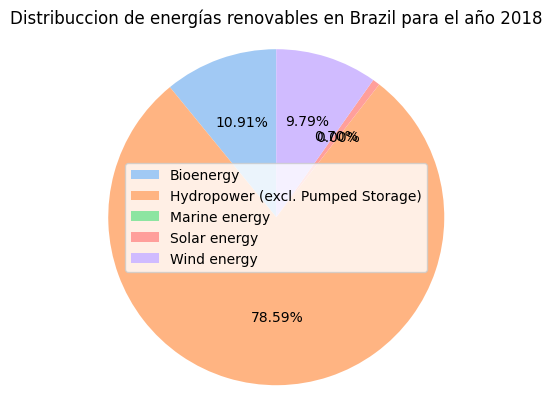

In [275]:
sns.color_palette("pastel")

plt.pie(data['total_generation_gwh'], autopct='%1.2f%%', startangle=90)
plt.axis('equal')
plt.title(f'Distribuccion de energías renovables en {country} para el año {year}')
plt.legend(labels=data['group_technology'])
plt.show()

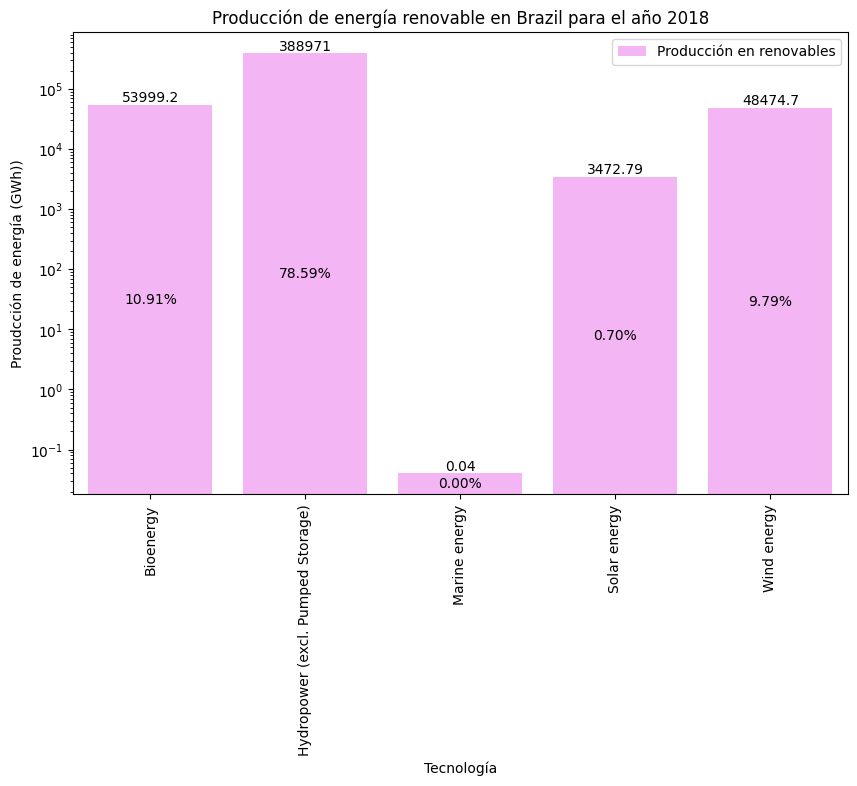

In [276]:
fig, ax = plt.subplots(figsize=(10, 6))

percentages = data['total_generation_gwh']/(data['total_generation_gwh'].sum())*100

sns.color_palette("pastel")
ax = sns.barplot(data=data, x='group_technology', y='total_generation_gwh', label='Producción en renovables', color='#ffaaff')
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[0], label_type='center',
             labels=[f'{val:.2f}%' for val in percentages],
             fontsize=10)
plt.title(f'Producción de energía renovable en {country} para el año {year}')
plt.xlabel('Tecnología')
plt.ylabel('Proudcción de energía (GWh))')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

###3.2. Por capacidad instalada

In [263]:
country = 'Brazil'
year = 2018

In [264]:
query_1 = f"SELECT country_id FROM countries WHERE name = '{country}';"
cur.execute(query_1)

cur.fetchall()

[(1,)]

In [265]:
query_2 = f"""
SELECT gt.name as group_technology, SUM(ed.electricity_installed_mw) AS total_capacity_mw
  FROM energy_data ed
  INNER JOIN sub_technology st ON ed.sub_tech_id = st.sub_technology_id
  INNER JOIN technology t ON st.technology_id = t.technology_id
  INNER JOIN group_technology gt ON t.group_technology_id = gt.group_technology_id
  WHERE gt.renewable = TRUE
  AND ed.year = {year}
  AND ed.country_id IN (SELECT country_id FROM countries WHERE name = '{country}')
  GROUP BY gt.name;
"""
cur.execute(query_2)
data = pd.DataFrame(cur.fetchall())
data.columns = [i[0] for i in cur.description]
data

,group_technology,total_capacity_mw
0,Bioenergy,15142.54
1,Geothermal energy,NaN
2,Hydropower (excl. Pumped Storage),107747.66
3,Marine energy,0.05
4,Multiple renewables*,NaN
5,Solar energy,2467.65
6,Wind energy,14514.01


In [269]:
nulls_index = data[data['total_capacity_mw'].isna()].index
data.drop(nulls_index, inplace=True)
data

,group_technology,total_capacity_mw
0,Bioenergy,15142.54
2,Hydropower (excl. Pumped Storage),107747.66
3,Marine energy,0.05
5,Solar energy,2467.65
6,Wind energy,14514.01


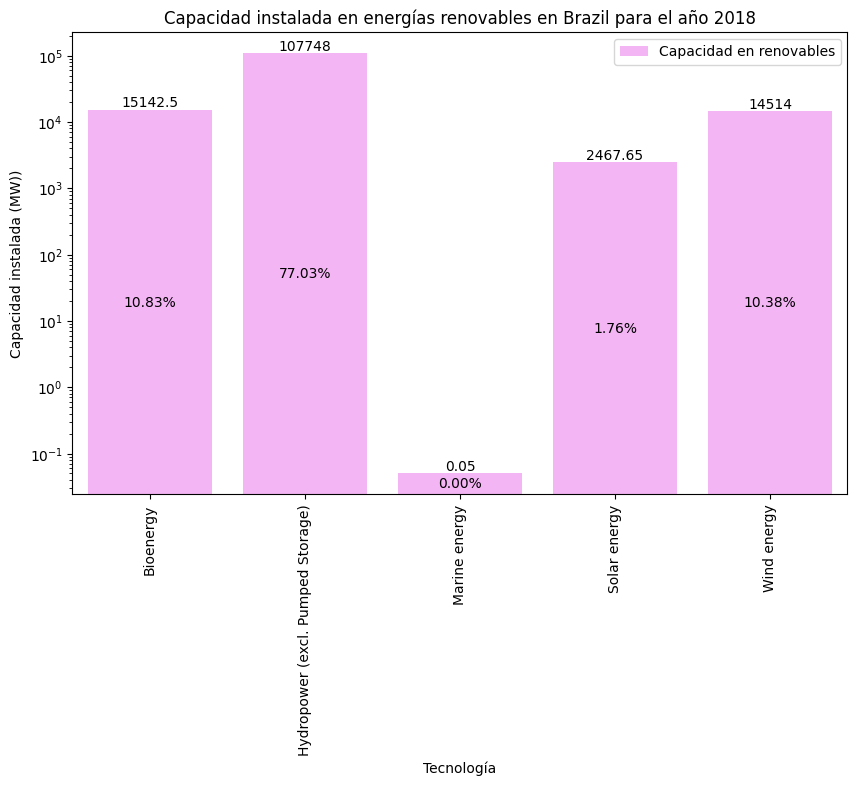

In [271]:
fig, ax = plt.subplots(figsize=(10, 6))

percentages = data['total_capacity_mw']/(data['total_capacity_mw'].sum())*100

ax = sns.barplot(data=data, x='group_technology', y='total_capacity_mw', label='Capacidad en renovables', color='#ffaaff')
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[0], label_type='center',
             labels=[f'{val:.2f}%' for val in percentages],
             fontsize=10)

plt.title(f'Capacidad instalada en energías renovables en {country} para el año {year}')
plt.xlabel('Tecnología')
plt.ylabel('Capacidad instalada (MW))')
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

##4. Datos históricos

###4.1. Por generación de energía

In [359]:
query_1 = f"""
SELECT ed.year, c.name, SUM(ed.electricity_generation_gwh) AS total_renewable_gwh
FROM energy_data ed
INNER JOIN countries c ON ed.country_id = c.country_id
WHERE ed.sub_tech_id IN
(
  SELECT st.sub_technology_id
  FROM sub_technology st
  INNER JOIN technology t ON st.technology_id = t.technology_id
  INNER JOIN group_technology gt ON t.group_technology_id = gt.group_technology_id
  WHERE gt.renewable = TRUE
)
AND ed.year BETWEEN 2008 AND 2023
GROUP BY ed.year, c.country_id
ORDER BY ed.year ASC;
"""
cur.execute(query_1)
renewables = pd.DataFrame(cur.fetchall())
renewables.columns = [i[0] for i in cur.description]
renewables

,year,name,total_renewable_gwh
0,2008,Argentina,32130.44
1,2008,Brazil,390318.55
2,2008,Chile,27735.00
3,2008,Colombia,53612.01
4,2008,Peru,19254.76
...,...,...,...
91,2023,Brazil,629903.73
92,2023,Chile,57621.06
93,2023,Colombia,62119.10
94,2023,Peru,32920.15


In [360]:
query_2 = f"""
SELECT ed.year, c.name, SUM(ed.electricity_generation_gwh) AS total_non_renewable_gwh
FROM energy_data ed
INNER JOIN countries c ON ed.country_id = c.country_id
WHERE ed.sub_tech_id IN
(
  SELECT st.sub_technology_id
  FROM sub_technology st
  INNER JOIN technology t ON st.technology_id = t.technology_id
  INNER JOIN group_technology gt ON t.group_technology_id = gt.group_technology_id
  WHERE gt.renewable = FALSE
)
AND ed.year BETWEEN 2008 AND 2023
GROUP BY ed.year, c.country_id
ORDER BY ed.year ASC;
"""
cur.execute(query_2)
non_renewables = pd.DataFrame(cur.fetchall())
non_renewables.columns = [i[0] for i in cur.description]
non_renewables

,year,name,total_non_renewable_gwh
0,2008,Argentina,89885.39
1,2008,Brazil,72645.92
2,2008,Chile,33012.00
3,2008,Colombia,9065.54
4,2008,Peru,12929.00
...,...,...,...
91,2023,Brazil,77933.32
92,2023,Chile,33553.03
93,2023,Colombia,30326.44
94,2023,Peru,28887.59


In [361]:
historic_data = pd.merge(renewables, non_renewables, on=['year', 'name'], suffixes=('_renewable', '_non_renewable'))
historic_data['total_energy_generation_gwh'] = historic_data['total_renewable_gwh'] + historic_data['total_non_renewable_gwh']
historic_data

,year,name,total_renewable_gwh,total_non_renewable_gwh,total_energy_generation_gwh
0,2008,Argentina,32130.44,89885.39,122015.83
1,2008,Brazil,390318.55,72645.92,462964.47
2,2008,Chile,27735.00,33012.00,60747.00
3,2008,Colombia,53612.01,9065.54,62677.55
4,2008,Peru,19254.76,12929.00,32183.76
...,...,...,...,...,...
91,2023,Brazil,629903.73,77933.32,707837.05
92,2023,Chile,57621.06,33553.03,91174.09
93,2023,Colombia,62119.10,30326.44,92445.54
94,2023,Peru,32920.15,28887.59,61807.74


In [362]:
c_query = "SELECT name FROM countries;"
cur.execute(c_query)
countries = pd.DataFrame(cur.fetchall())
countries.columns = [i[0] for i in cur.description]
countries
#

,name
0,Argentina
1,Brazil
2,Chile
3,Colombia
4,Peru
5,Uruguay


In [363]:
country_df = historic_data[historic_data['name'] == 'Argentina'][['year','total_renewable_gwh']]
country_df

,year,total_renewable_gwh
0,2008,32130.44
6,2009,35608.84
12,2010,34548.39
18,2011,32572.85
24,2012,31032.46
30,2013,35100.91
36,2014,34472.40
42,2015,34255.46
48,2016,31664.88
54,2017,33986.15


In [364]:
country_df.set_index('year', inplace=True)

In [365]:
country_df

,total_renewable_gwh
year,
2008,32130.44
2009,35608.84
2010,34548.39
2011,32572.85
2012,31032.46
2013,35100.91
2014,34472.40
2015,34255.46
2016,31664.88


In [366]:
country_df.rename(columns={'total_renewable_gwh':'Argentina'}, inplace=True)
country_df

,Argentina
year,
2008,32130.44
2009,35608.84
2010,34548.39
2011,32572.85
2012,31032.46
2013,35100.91
2014,34472.40
2015,34255.46
2016,31664.88


In [367]:
renew_dict = {}
non_renew_dict = {}
for country in countries['name']:
  country_df = historic_data[historic_data['name'] == country][['year','total_renewable_gwh']]
  country_df.set_index('year', inplace=True)
  country_df.rename(columns={'total_renewable_gwh':country}, inplace=True)
  print(f"Total filas para {country}: {country_df.shape[0]}")
  renew_dict[country] = country_df
  country_nr_df = historic_data[historic_data['name'] == country][['year','total_non_renewable_gwh']]
  country_nr_df.set_index('year', inplace=True)
  country_nr_df.rename(columns={'total_non_renewable_gwh':country}, inplace=True)
  print(f"Total filas para {country}: {country_nr_df.shape[0]}")
  non_renew_dict[country] = country_nr_df


Total filas para Argentina: 16
Total filas para Argentina: 16
Total filas para Brazil: 16
Total filas para Brazil: 16
Total filas para Chile: 16
Total filas para Chile: 16
Total filas para Colombia: 16
Total filas para Colombia: 16
Total filas para Peru: 16
Total filas para Peru: 16
Total filas para Uruguay: 16
Total filas para Uruguay: 16


In [368]:
data_renewable = pd.DataFrame()
for country in renew_dict.keys():
  data_renewable = pd.concat([data_renewable, renew_dict[country]], axis=1)

data_renewable.head()

,Argentina,Brazil,Chile,Colombia,Peru,Uruguay
year,,,,,,
2008,32130.44,390318.55,27735.00,53612.01,19254.76,5371.13
2009,35608.84,414869.15,30146.00,46193.98,20116.82,6148.84
2010,34548.39,437016.21,24638.22,47955.13,20272.33,9828.61
2011,32572.85,463280.65,26106.23,66870.35,21872.06,7720.96
2012,31032.46,455692.10,25638.03,58037.81,22458.74,6850.11


In [369]:
data_non_renewable = pd.DataFrame()
for country in renew_dict.keys():
  data_non_renewable = pd.concat([data_non_renewable, non_renew_dict[country]], axis=1)

data_non_renewable.head()

,Argentina,Brazil,Chile,Colombia,Peru,Uruguay
year,,,,,,
2008,89885.39,72645.92,33012.0,9065.54,12929.00,3412.05
2009,86844.67,51056.19,31260.0,15400.09,12977.00,2523.47
2010,91471.89,78389.50,36355.0,17452.09,15173.99,911.43
2011,96935.90,68091.77,40515.0,11306.09,16572.91,2630.49
2012,104854.16,101779.55,45088.0,13798.17,17319.50,3752.79


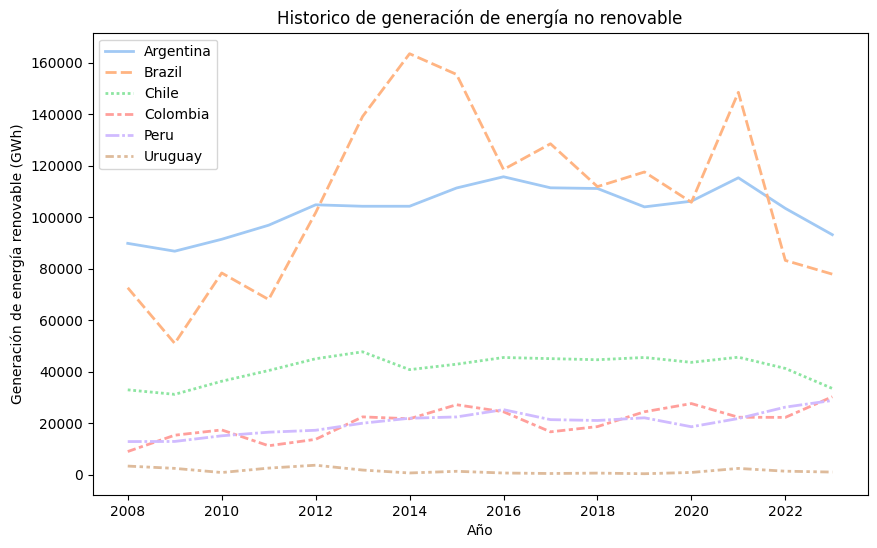

In [370]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=data_non_renewable, linewidth=2)
plt.title("Historico de generación de energía no renovable")
plt.xlabel("Año")
plt.ylabel("Generación de energía renovable (GWh)")
plt.show()

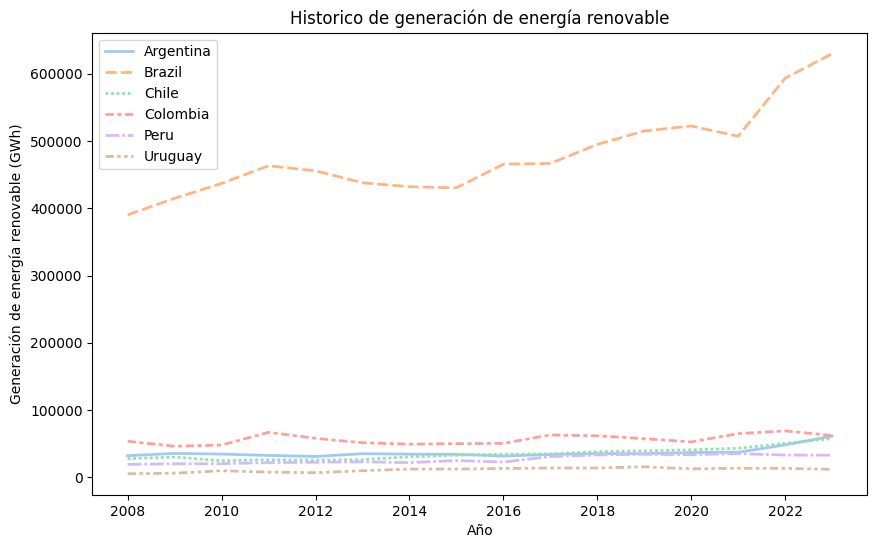

In [371]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=data_renewable, linewidth=2)
plt.title("Historico de generación de energía renovable")
plt.xlabel("Año")
plt.ylabel("Generación de energía renovable (GWh)")
plt.show()

##5. Datos historicos por país

###5.1. Renovables

In [319]:
country = 'Brazil'

In [325]:
query_c = f"""
SELECT ed.year, gt.name as group_technology, SUM(ed.electricity_generation_gwh) AS total_generation_gwh
  FROM energy_data ed
  INNER JOIN sub_technology st ON ed.sub_tech_id = st.sub_technology_id
  INNER JOIN technology t ON st.technology_id = t.technology_id
  INNER JOIN group_technology gt ON t.group_technology_id = gt.group_technology_id
  WHERE gt.renewable = TRUE
  AND ed.year BETWEEN 2008 AND 2023
  AND ed.country_id IN (SELECT country_id FROM countries WHERE name = '{country}')
  GROUP BY gt.name, ed.year;
"""
cur.execute(query_c)
country_data = pd.DataFrame(cur.fetchall())
country_data.columns = [i[0] for i in cur.description]
country_data

,year,group_technology,total_generation_gwh
0,2008,Bioenergy,19575.50
1,2009,Bioenergy,22639.24
2,2010,Bioenergy,31545.25
3,2011,Bioenergy,32234.65
4,2012,Bioenergy,35293.97
...,...,...,...
107,2019,Wind energy,55985.90
108,2020,Wind energy,57050.32
109,2021,Wind energy,72285.97
110,2022,Wind energy,81631.71


In [326]:
country_data.shape

(112, 3)

In [330]:
tech_dict = {}

for tech in country_data['group_technology'].unique():
  tech_df = country_data[country_data['group_technology'] == tech][['year','total_generation_gwh']]
  tech_df.set_index('year', inplace=True)
  tech_df.rename(columns={'total_generation_gwh':tech}, inplace=True)
  print(f"Total filas para {tech}: {tech_df.shape[0]}")
  tech_dict[tech] = tech_df


Total filas para Bioenergy: 16
Total filas para Geothermal energy: 16
Total filas para Hydropower (excl. Pumped Storage): 16
Total filas para Marine energy: 16
Total filas para Multiple renewables*: 16
Total filas para Solar energy: 16
Total filas para Wind energy: 16


In [332]:
data_renewable = pd.DataFrame()
for tech in tech_dict.keys():
  data_renewable = pd.concat([data_renewable, tech_dict[tech]], axis=1)

data_renewable.head()

,Bioenergy,Geothermal energy,Hydropower (excl. Pumped Storage),Marine energy,Multiple renewables*,Solar energy,Wind energy
year,,,,,,,
2008,19575.50,NaN,369556.40,NaN,NaN,3.65,1183.00
2009,22639.24,NaN,390988.07,NaN,NaN,3.84,1238.00
2010,31545.25,NaN,403289.91,NaN,NaN,4.05,2177.00
2011,32234.65,NaN,428333.02,NaN,NaN,8.48,2704.50
2012,35293.97,NaN,415342.28,0.09,NaN,5.71,5050.05


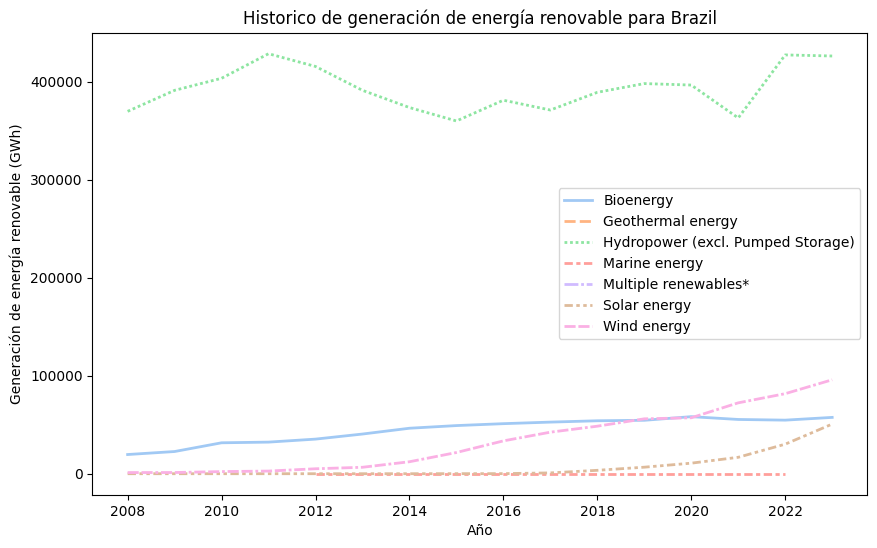

In [334]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=data_renewable, linewidth=2)
plt.title(f"Historico de generación de energía renovable para {country}")
plt.xlabel("Año")
plt.ylabel("Generación de energía renovable (GWh)")
plt.show()